In [13]:
# CELL 1: INITIAL SETUP AND DATA LOADING
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from collections import Counter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set the style of matplotlib
plt.style.use('fivethirtyeight')

# Load training and testing datasets
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

print("Data loaded successfully!")
print(f"Training shape: {train.shape}")
print(f"Test shape: {test.shape}")

Data loaded successfully!
Training shape: (76518, 37)
Test shape: (51012, 36)


In [14]:
# CELL 2: REMOVE IRRELEVANT COLUMNS FOR MOROCCAN CONTEXT
columns_to_remove = [
    'Unemployment rate',
    'Inflation rate', 
    'GDP',
    'Marital status',
    'Application mode',
    'Daytime/evening attendance',
    "Mother's qualification",
    "Father's qualification",
    'Debtor',
    'Tuition fees up to date',
    'Displaced'
]

# Check which columns actually exist
existing_columns_to_remove = [col for col in columns_to_remove if col in train.columns]
print(f"Removing {len(existing_columns_to_remove)} columns: {existing_columns_to_remove}")

# Remove columns
if existing_columns_to_remove:
    train = train.drop(columns=existing_columns_to_remove)
    test = test.drop(columns=existing_columns_to_remove)

print(f"✅ Columns removed. New shapes - Train: {train.shape}, Test: {test.shape}")

Removing 11 columns: ['Unemployment rate', 'Inflation rate', 'GDP', 'Marital status', 'Application mode', 'Daytime/evening attendance', "Mother's qualification", "Father's qualification", 'Debtor', 'Tuition fees up to date', 'Displaced']
✅ Columns removed. New shapes - Train: (76518, 26), Test: (51012, 25)


=== TARGET VARIABLE ANALYSIS ===
Target distribution:
Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

Target proportions:
Target
Graduate    0.474
Dropout     0.331
Enrolled    0.195
Name: proportion, dtype: float64


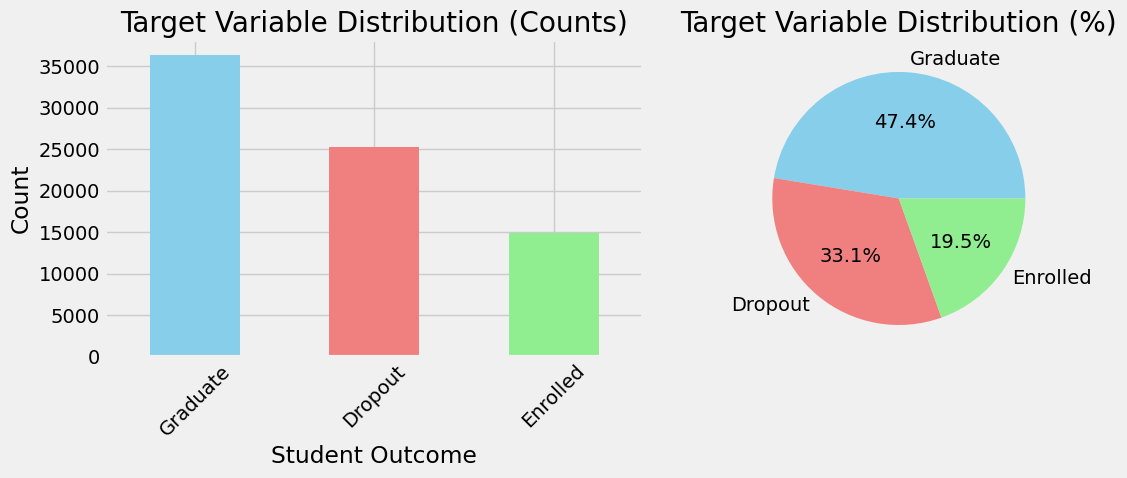


=== MISSING VALUES CHECK ===
Total missing values: 0
✅ No missing values found!


In [15]:
# CELL 3: EXPLORATORY DATA ANALYSIS
print("=== TARGET VARIABLE ANALYSIS ===")
print("Target distribution:")
print(train['Target'].value_counts())
print(f"\nTarget proportions:")
print(train['Target'].value_counts(normalize=True).round(3))

# Visualize target distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train['Target'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Target Variable Distribution (Counts)')
plt.xlabel('Student Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
train['Target'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', 
                                                  colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Target Variable Distribution (%)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Check for missing values
print("\n=== MISSING VALUES CHECK ===")
missing_values = train.isnull().sum().sum()
print(f"Total missing values: {missing_values}")
if missing_values == 0:
    print("✅ No missing values found!")

In [16]:
# CELL 4: OUTLIER DETECTION AND TREATMENT
print("=== OUTLIER ANALYSIS AND TREATMENT ===")

# Create copies for processing
train_processed = train.copy()
test_processed = test.copy()

# Outlier detection function
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Outlier treatment function
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    original_outliers = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"  {column}: Capped {original_outliers} outliers")
    return df

# Get numerical columns
numerical_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'Target']

# Identify high outlier columns (>15% outliers)
high_outlier_cols = []
for col in numerical_cols:
    outliers, _, _ = detect_outliers_iqr(train_processed, col)
    outlier_percentage = len(outliers) / len(train_processed) * 100
    if outlier_percentage > 15:
        high_outlier_cols.append(col)

print(f"Treating outliers in {len(high_outlier_cols)} features with >15% outliers...")

# Apply outlier treatment
for col in high_outlier_cols:
    train_processed = cap_outliers(train_processed, col)
    test_processed = cap_outliers(test_processed, col)

print("✅ Outlier treatment completed")

=== OUTLIER ANALYSIS AND TREATMENT ===
Treating outliers in 4 features with >15% outliers...
  Scholarship holder: Capped 18930 outliers
  Scholarship holder: Capped 12431 outliers
  Curricular units 1st sem (grade): Capped 16059 outliers
  Curricular units 1st sem (grade): Capped 10393 outliers
  Curricular units 2nd sem (enrolled): Capped 14416 outliers
  Curricular units 2nd sem (enrolled): Capped 9452 outliers
  Curricular units 2nd sem (grade): Capped 18482 outliers
  Curricular units 2nd sem (grade): Capped 11986 outliers
✅ Outlier treatment completed


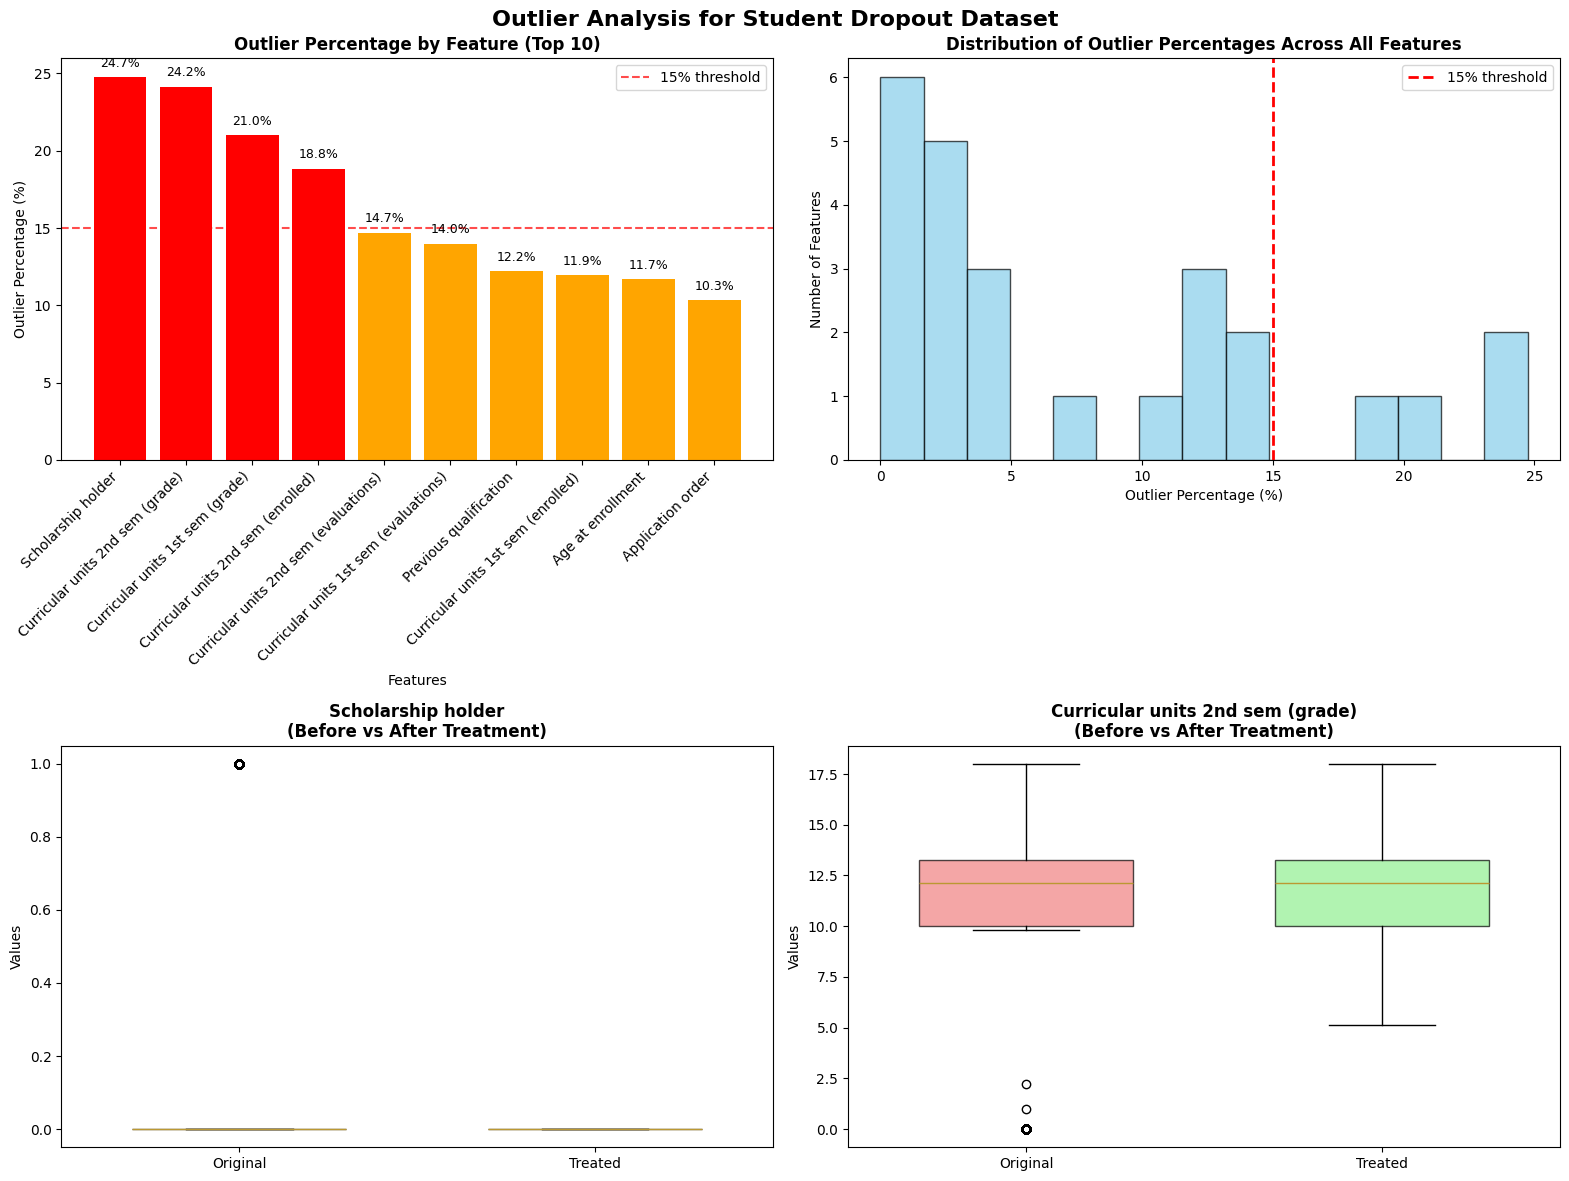

OUTLIER ANALYSIS SUMMARY
Total features analyzed: 25
Features with outliers: 24
Features with >15% outliers (requiring treatment): 4

Features requiring outlier treatment:
  • Scholarship holder: 18,930 outliers (24.7%)
  • Curricular units 2nd sem (grade): 18,482 outliers (24.2%)
  • Curricular units 1st sem (grade): 16,059 outliers (21.0%)
  • Curricular units 2nd sem (enrolled): 14,416 outliers (18.8%)

Top 5 features by outlier percentage:
  1. Scholarship holder: 24.7% - ⚠️ Requires treatment
  2. Curricular units 2nd sem (grade): 24.2% - ⚠️ Requires treatment
  3. Curricular units 1st sem (grade): 21.0% - ⚠️ Requires treatment
  4. Curricular units 2nd sem (enrolled): 18.8% - ⚠️ Requires treatment
  5. Curricular units 2nd sem (evaluations): 14.7% - ✅ Within acceptable range

Overall dataset outlier statistics:
  Total outliers across all features: 149,834
  Overall outlier rate: 7.83%


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Outlier detection function (same as yours)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Get numerical columns
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'Target']

# Identify high outlier columns and their percentages
outlier_info = []
for col in numerical_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(train, col)
    outlier_percentage = len(outliers) / len(train) * 100
    outlier_info.append({
        'column': col,
        'outlier_count': len(outliers),
        'outlier_percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })

# Sort by outlier percentage
outlier_info.sort(key=lambda x: x['outlier_percentage'], reverse=True)

# Create the visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Outlier Analysis for Student Dropout Dataset', fontsize=16, fontweight='bold')

# 1. Outlier percentage by feature (bar chart)
top_10_outliers = outlier_info[:10]  # Top 10 features with most outliers
feature_names = [info['column'] for info in top_10_outliers]
outlier_percentages = [info['outlier_percentage'] for info in top_10_outliers]

bars = axes[0, 0].bar(range(len(feature_names)), outlier_percentages, 
                      color=['red' if x > 15 else 'orange' if x > 10 else 'green' for x in outlier_percentages])
axes[0, 0].set_title('Outlier Percentage by Feature (Top 10)', fontweight='bold')
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Outlier Percentage (%)')
axes[0, 0].set_xticks(range(len(feature_names)))
axes[0, 0].set_xticklabels(feature_names, rotation=45, ha='right')
axes[0, 0].axhline(y=15, color='red', linestyle='--', alpha=0.7, label='15% threshold')
axes[0, 0].legend()

# Add percentage labels on bars
for i, (bar, pct) in enumerate(zip(bars, outlier_percentages)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Distribution of outlier percentages (histogram)
all_percentages = [info['outlier_percentage'] for info in outlier_info]
axes[0, 1].hist(all_percentages, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=15, color='red', linestyle='--', linewidth=2, label='15% threshold')
axes[0, 1].set_title('Distribution of Outlier Percentages Across All Features', fontweight='bold')
axes[0, 1].set_xlabel('Outlier Percentage (%)')
axes[0, 1].set_ylabel('Number of Features')
axes[0, 1].legend()

# 3. Box plot comparison (before vs after) for top outlier features
high_outlier_features = [info['column'] for info in outlier_info if info['outlier_percentage'] > 15][:4]

if len(high_outlier_features) > 0:
    # Show box plots for top 4 features with >15% outliers
    for i, col in enumerate(high_outlier_features[:4]):
        if i < 2:
            row, col_idx = 1, i
        else:
            # If more than 2 features, we'll show them in a different way
            break
            
        # Original data box plot
        axes[row, col_idx].boxplot([train[col]], positions=[1], widths=0.6, 
                                  patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.7))
        
        # Simulated treated data (capped outliers)
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        treated_data = train[col].clip(lower=lower_bound, upper=upper_bound)
        
        axes[row, col_idx].boxplot([treated_data], positions=[2], widths=0.6, 
                                  patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7))
        
        axes[row, col_idx].set_title(f'{col}\n(Before vs After Treatment)', fontweight='bold')
        axes[row, col_idx].set_xticklabels(['Original', 'Treated'])
        axes[row, col_idx].set_ylabel('Values')
        
else:
    # If no high outlier features, show a summary instead
    axes[1, 0].text(0.5, 0.5, 'No features with >15% outliers\nfound in the dataset', 
                   ha='center', va='center', fontsize=14, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('High Outlier Features', fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].text(0.5, 0.5, 'Outlier treatment not\nrequired for this dataset', 
                   ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Treatment Status', fontweight='bold')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("OUTLIER ANALYSIS SUMMARY")
print("=" * 60)

features_with_outliers = [info for info in outlier_info if info['outlier_count'] > 0]
high_outlier_features_list = [info for info in outlier_info if info['outlier_percentage'] > 15]

print(f"Total features analyzed: {len(numerical_cols)}")
print(f"Features with outliers: {len(features_with_outliers)}")
print(f"Features with >15% outliers (requiring treatment): {len(high_outlier_features_list)}")

if len(high_outlier_features_list) > 0:
    print(f"\nFeatures requiring outlier treatment:")
    for info in high_outlier_features_list:
        print(f"  • {info['column']}: {info['outlier_count']:,} outliers ({info['outlier_percentage']:.1f}%)")
else:
    print(f"\n✅ No features require outlier treatment (none exceed 15% threshold)")

print(f"\nTop 5 features by outlier percentage:")
for i, info in enumerate(outlier_info[:5]):
    status = "⚠️ Requires treatment" if info['outlier_percentage'] > 15 else "✅ Within acceptable range"
    print(f"  {i+1}. {info['column']}: {info['outlier_percentage']:.1f}% - {status}")

# Calculate total outliers across dataset
total_outliers = sum(info['outlier_count'] for info in features_with_outliers)
total_data_points = len(train) * len(numerical_cols)
overall_outlier_rate = total_outliers / total_data_points * 100

print(f"\nOverall dataset outlier statistics:")
print(f"  Total outliers across all features: {total_outliers:,}")
print(f"  Overall outlier rate: {overall_outlier_rate:.2f}%")

In [17]:
# CELL 5: BASIC FEATURE ENGINEERING
print("=== BASIC FEATURE ENGINEERING ===")

# Academic success rates
train_processed['1st_sem_success_rate'] = (
    train_processed['Curricular units 1st sem (approved)'] / 
    train_processed['Curricular units 1st sem (enrolled)'].replace(0, 1)
)

train_processed['2nd_sem_success_rate'] = (
    train_processed['Curricular units 2nd sem (approved)'] / 
    train_processed['Curricular units 2nd sem (enrolled)'].replace(0, 1)
)

# Overall academic performance
train_processed['overall_success_rate'] = (
    (train_processed['1st_sem_success_rate'] + train_processed['2nd_sem_success_rate']) / 2
)

# Grade improvement
train_processed['grade_improvement'] = (
    train_processed['Curricular units 2nd sem (grade)'] - 
    train_processed['Curricular units 1st sem (grade)']
)

# Apply same to test set
test_processed['1st_sem_success_rate'] = (
    test_processed['Curricular units 1st sem (approved)'] / 
    test_processed['Curricular units 1st sem (enrolled)'].replace(0, 1)
)

test_processed['2nd_sem_success_rate'] = (
    test_processed['Curricular units 2nd sem (approved)'] / 
    test_processed['Curricular units 2nd sem (enrolled)'].replace(0, 1)
)

test_processed['overall_success_rate'] = (
    (test_processed['1st_sem_success_rate'] + test_processed['2nd_sem_success_rate']) / 2
)

test_processed['grade_improvement'] = (
    test_processed['Curricular units 2nd sem (grade)'] - 
    test_processed['Curricular units 1st sem (grade)']
)

print("✅ Basic feature engineering completed")
print(f"New shape - Train: {train_processed.shape}, Test: {test_processed.shape}")

=== BASIC FEATURE ENGINEERING ===
✅ Basic feature engineering completed
New shape - Train: (76518, 30), Test: (51012, 29)


In [18]:
# CELL 6: ADVANCED FEATURE ENGINEERING
print("=== ADVANCED FEATURE ENGINEERING ===")

# 1. Academic Performance Changes
print("1. Creating academic performance indicators...")

train_processed['units_enrolled_change'] = (
    train_processed['Curricular units 2nd sem (enrolled)'] - 
    train_processed['Curricular units 1st sem (enrolled)']
)

train_processed['units_approved_change'] = (
    train_processed['Curricular units 2nd sem (approved)'] - 
    train_processed['Curricular units 1st sem (approved)']
)

train_processed['grade_consistency'] = abs(
    train_processed['Curricular units 2nd sem (grade)'] - 
    train_processed['Curricular units 1st sem (grade)']
)

# 2. Failure Rates
train_processed['1st_sem_failure_rate'] = (
    (train_processed['Curricular units 1st sem (enrolled)'] - 
     train_processed['Curricular units 1st sem (approved)']) / 
    train_processed['Curricular units 1st sem (enrolled)'].replace(0, 1)
)

train_processed['2nd_sem_failure_rate'] = (
    (train_processed['Curricular units 2nd sem (enrolled)'] - 
     train_processed['Curricular units 2nd sem (approved)']) / 
    train_processed['Curricular units 2nd sem (enrolled)'].replace(0, 1)
)

# 3. Risk Indicators
print("2. Creating risk indicators...")

train_processed['age_risk'] = ((train_processed['Age at enrollment'] < 18) | 
                              (train_processed['Age at enrollment'] > 25)).astype(int)

train_processed['high_academic_load_1st'] = (
    train_processed['Curricular units 1st sem (enrolled)'] > 
    train_processed['Curricular units 1st sem (enrolled)'].quantile(0.75)
).astype(int)

train_processed['high_academic_load_2nd'] = (
    train_processed['Curricular units 2nd sem (enrolled)'] > 
    train_processed['Curricular units 2nd sem (enrolled)'].quantile(0.75)
).astype(int)

# 4. Interaction Features
print("3. Creating interaction features...")

train_processed['scholarship_performance'] = (
    train_processed['Scholarship holder'] * train_processed['overall_success_rate']
)

train_processed['age_performance'] = (
    train_processed['Age at enrollment'] * train_processed['overall_success_rate']
)

train_processed['gender_course'] = train_processed['Gender'] * train_processed['Course']

# Apply same to test set
advanced_features = ['units_enrolled_change', 'units_approved_change', 'grade_consistency',
                    '1st_sem_failure_rate', '2nd_sem_failure_rate', 'age_risk',
                    'high_academic_load_1st', 'high_academic_load_2nd', 
                    'scholarship_performance', 'age_performance', 'gender_course']

# Replicate for test set
test_processed['units_enrolled_change'] = (
    test_processed['Curricular units 2nd sem (enrolled)'] - 
    test_processed['Curricular units 1st sem (enrolled)']
)

test_processed['units_approved_change'] = (
    test_processed['Curricular units 2nd sem (approved)'] - 
    test_processed['Curricular units 1st sem (approved)']
)

test_processed['grade_consistency'] = abs(
    test_processed['Curricular units 2nd sem (grade)'] - 
    test_processed['Curricular units 1st sem (grade)']
)

test_processed['1st_sem_failure_rate'] = (
    (test_processed['Curricular units 1st sem (enrolled)'] - 
     test_processed['Curricular units 1st sem (approved)']) / 
    test_processed['Curricular units 1st sem (enrolled)'].replace(0, 1)
)

test_processed['2nd_sem_failure_rate'] = (
    (test_processed['Curricular units 2nd sem (enrolled)'] - 
     test_processed['Curricular units 2nd sem (approved)']) / 
    test_processed['Curricular units 2nd sem (enrolled)'].replace(0, 1)
)

test_processed['age_risk'] = ((test_processed['Age at enrollment'] < 18) | 
                             (test_processed['Age at enrollment'] > 25)).astype(int)

test_processed['high_academic_load_1st'] = (
    test_processed['Curricular units 1st sem (enrolled)'] > 
    train_processed['Curricular units 1st sem (enrolled)'].quantile(0.75)  # Use train quantile
).astype(int)

test_processed['high_academic_load_2nd'] = (
    test_processed['Curricular units 2nd sem (enrolled)'] > 
    train_processed['Curricular units 2nd sem (enrolled)'].quantile(0.75)  # Use train quantile
).astype(int)

test_processed['scholarship_performance'] = (
    test_processed['Scholarship holder'] * test_processed['overall_success_rate']
)

test_processed['age_performance'] = (
    test_processed['Age at enrollment'] * test_processed['overall_success_rate']
)

test_processed['gender_course'] = test_processed['Gender'] * test_processed['Course']

print(f"✅ Advanced features created. New shape - Train: {train_processed.shape}, Test: {test_processed.shape}")

=== ADVANCED FEATURE ENGINEERING ===
1. Creating academic performance indicators...
2. Creating risk indicators...
3. Creating interaction features...
✅ Advanced features created. New shape - Train: (76518, 41), Test: (51012, 40)


In [19]:
# CELL 7: FEATURE SELECTION
print("=== FEATURE SELECTION ===")

# Prepare data for feature selection
X_full = train_processed.drop('Target', axis=1)
y = train_processed['Target']

# 1. Statistical Feature Selection (F-test)
print("1. F-test feature selection...")
selector_f = SelectKBest(score_func=f_classif, k=25)
X_f_selected = selector_f.fit_transform(X_full, y)
selected_features_f = X_full.columns[selector_f.get_support()].tolist()

# 2. Mutual Information Feature Selection
print("2. Mutual information feature selection...")
selector_mi = SelectKBest(score_func=mutual_info_classif, k=25)
X_mi_selected = selector_mi.fit_transform(X_full, y)
selected_features_mi = X_full.columns[selector_mi.get_support()].tolist()

# 3. Random Forest Feature Importance
print("3. Random Forest feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_full, y)

feature_importance = pd.DataFrame({
    'feature': X_full.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

top_rf_features = feature_importance.head(25)['feature'].tolist()

print("Top 15 features by Random Forest importance:")
print(feature_importance.head(15))

# 4. Combine selected features (take union of all methods)
all_selected_features = list(set(selected_features_f + selected_features_mi + top_rf_features))
print(f"\n✅ Selected {len(all_selected_features)} features from {X_full.shape[1]} total features")

# Create datasets with selected features
X_selected = X_full[all_selected_features]
X_test_selected = test_processed[all_selected_features]

print(f"Selected features dataset shape - Train: {X_selected.shape}, Test: {X_test_selected.shape}")

=== FEATURE SELECTION ===
1. F-test feature selection...
2. Mutual information feature selection...
3. Random Forest feature importance...
Top 15 features by Random Forest importance:
                                   feature  importance
27                    overall_success_rate    0.113820
33                    2nd_sem_failure_rate    0.103327
26                    2nd_sem_success_rate    0.098200
38                         age_performance    0.056763
23        Curricular units 2nd sem (grade)    0.052836
22     Curricular units 2nd sem (approved)    0.052780
7                          Admission grade    0.048733
28                       grade_improvement    0.048035
17        Curricular units 1st sem (grade)    0.041920
3           Previous qualification (grade)    0.039498
31                       grade_consistency    0.031474
6                      Father's occupation    0.028951
32                    1st_sem_failure_rate    0.028780
21  Curricular units 2nd sem (evaluations)    

In [20]:
# CELL 8: ADVANCED SCALING AND TRANSFORMATION
print("=== ADVANCED SCALING AND TRANSFORMATION ===")

# 1. Robust Scaling (less sensitive to outliers)
print("1. Applying Robust Scaling...")
robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X_selected)

# 2. Power Transform for better normality
print("2. Applying Power Transform...")
power_transformer = PowerTransformer(method='yeo-johnson')
X_power_transformed = power_transformer.fit_transform(X_robust_scaled)

# Convert back to DataFrames
X_final_scaled = pd.DataFrame(
    X_power_transformed, 
    columns=X_selected.columns, 
    index=X_selected.index
)

# Transform test set
X_test_robust = robust_scaler.transform(X_test_selected)
X_test_power = power_transformer.transform(X_test_robust)

X_test_final_scaled = pd.DataFrame(
    X_test_power, 
    columns=X_test_selected.columns, 
    index=X_test_selected.index
)

print(f"✅ Advanced scaling completed")
print(f"Final scaled shape - Train: {X_final_scaled.shape}, Test: {X_test_final_scaled.shape}")

# Check scaling effectiveness
print(f"Scaled data mean: {X_final_scaled.mean().mean():.6f}")
print(f"Scaled data std: {X_final_scaled.std().mean():.6f}")

=== ADVANCED SCALING AND TRANSFORMATION ===
1. Applying Robust Scaling...
2. Applying Power Transform...
✅ Advanced scaling completed
Final scaled shape - Train: (76518, 30), Test: (51012, 30)
Scaled data mean: 0.000000
Scaled data std: 1.000007


In [21]:
# CELL 9: ADVANCED CLASS BALANCING
print("=== ADVANCED CLASS BALANCING ===")

print("Original class distribution:")
print(y.value_counts())
print(f"Proportions: {y.value_counts(normalize=True).round(3)}")

# Method 1: SMOTE + Tomek (removes overlapping samples after SMOTE)
print("\n1. Applying SMOTE + Tomek...")
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_final_scaled, y)

print(f"SMOTE + Tomek results:")
print(f"Shape: {X_smote_tomek.shape}")
print(f"Class distribution: {Counter(y_smote_tomek)}")

# Method 2: ADASYN (Adaptive Synthetic Sampling)
print("\n2. Applying ADASYN...")
try:
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_final_scaled, y)
    
    print(f"ADASYN results:")
    print(f"Shape: {X_adasyn.shape}")
    print(f"Class distribution: {Counter(y_adasyn)}")
    
    # Choose ADASYN if it works well
    X_final_balanced = X_adasyn
    y_final_balanced = y_adasyn
    chosen_method = "ADASYN"
    
except Exception as e:
    print(f"ADASYN failed: {e}")
    print("Using SMOTE + Tomek instead...")
    X_final_balanced = X_smote_tomek
    y_final_balanced = y_smote_tomek
    chosen_method = "SMOTE + Tomek"

print(f"\n✅ Final balancing method: {chosen_method}")
print(f"Final balanced dataset shape: {X_final_balanced.shape}")

# Calculate class weights as backup option
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print(f"Class weights (for models that support it): {class_weight_dict}")

=== ADVANCED CLASS BALANCING ===
Original class distribution:
Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64
Proportions: Target
Graduate    0.474
Dropout     0.331
Enrolled    0.195
Name: proportion, dtype: float64

1. Applying SMOTE + Tomek...
SMOTE + Tomek results:
Shape: (106402, 30)
Class distribution: Counter({'Enrolled': 35615, 'Dropout': 35493, 'Graduate': 35294})

2. Applying ADASYN...
ADASYN results:
Shape: (110316, 30)
Class distribution: Counter({'Enrolled': 39115, 'Graduate': 36282, 'Dropout': 34919})

✅ Final balancing method: ADASYN
Final balanced dataset shape: (110316, 30)
Class weights (for models that support it): {'Dropout': np.float64(1.0083017077798861), 'Enrolled': np.float64(1.7072289156626506), 'Graduate': np.float64(0.7029932197784026)}


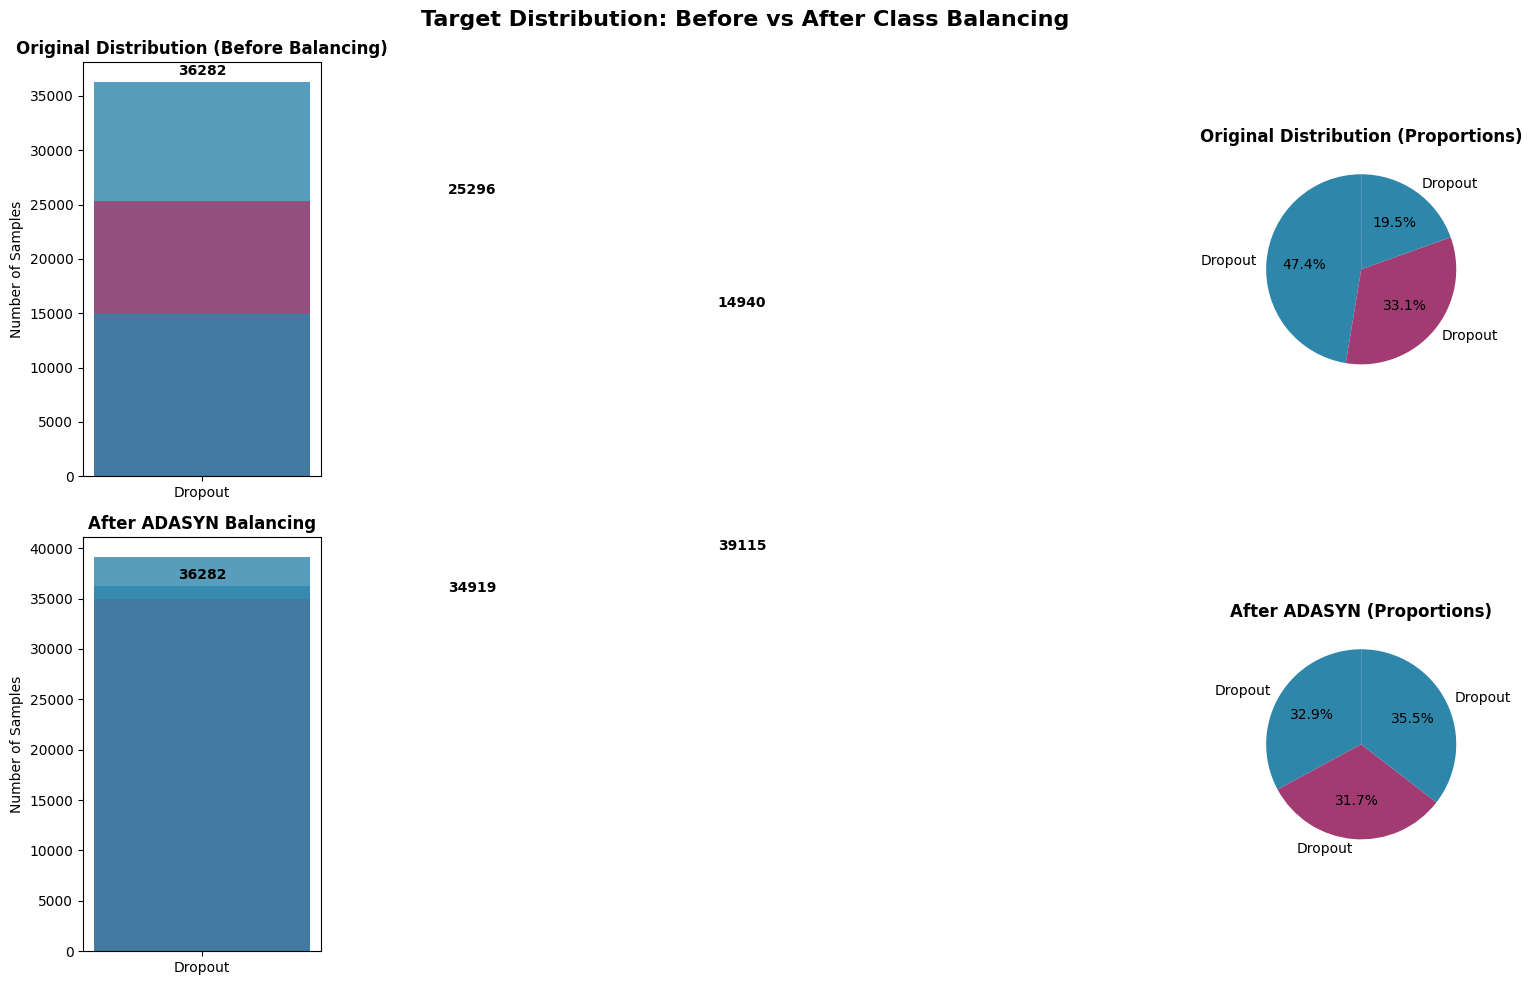

CLASS DISTRIBUTION SUMMARY
ORIGINAL DATASET:
  Total samples: 76518
  Dropout: 36282 samples (47.4%)
  Dropout: 25296 samples (33.1%)
  Dropout: 14940 samples (19.5%)

AFTER ADASYN BALANCING:
  Total samples: 110316
  Dropout: 36282 samples (32.9%)
  Dropout: 34919 samples (31.7%)
  Dropout: 39115 samples (35.5%)

IMPROVEMENT:
  Minority class samples increased by: 133.7%
  Dataset size increased by: 44.2%


In [22]:
# Visualizing Target Distribution Before and After Class Balancing
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Target Distribution: Before vs After Class Balancing', fontsize=16, fontweight='bold')

# Original distribution (before balancing)
original_counts = y.value_counts()
original_labels = ['Graduate' if x == 0 else 'Dropout' for x in original_counts.index]

# After balancing distribution
balanced_counts = Counter(y_final_balanced)
balanced_labels = ['Graduate' if x == 0 else 'Dropout' for x in balanced_counts.keys()]

# Plot 1: Original Distribution - Bar Chart
axes[0, 0].bar(original_labels, original_counts.values, color=['#2E86AB', '#A23B72'], alpha=0.8)
axes[0, 0].set_title('Original Distribution (Before Balancing)', fontweight='bold')
axes[0, 0].set_ylabel('Number of Samples')
for i, v in enumerate(original_counts.values):
    axes[0, 0].text(i, v + max(original_counts.values) * 0.01, str(v), 
                   ha='center', va='bottom', fontweight='bold')

# Plot 2: Original Distribution - Pie Chart
axes[0, 1].pie(original_counts.values, labels=original_labels, autopct='%1.1f%%', 
               colors=['#2E86AB', '#A23B72'], startangle=90)
axes[0, 1].set_title('Original Distribution (Proportions)', fontweight='bold')

# Plot 3: Balanced Distribution - Bar Chart
axes[1, 0].bar(balanced_labels, list(balanced_counts.values()), 
               color=['#2E86AB', '#A23B72'], alpha=0.8)
axes[1, 0].set_title(f'After {chosen_method} Balancing', fontweight='bold')
axes[1, 0].set_ylabel('Number of Samples')
for i, v in enumerate(balanced_counts.values()):
    axes[1, 0].text(i, v + max(balanced_counts.values()) * 0.01, str(v), 
                   ha='center', va='bottom', fontweight='bold')

# Plot 4: Balanced Distribution - Pie Chart
axes[1, 1].pie(list(balanced_counts.values()), labels=balanced_labels, autopct='%1.1f%%', 
               colors=['#2E86AB', '#A23B72'], startangle=90)
axes[1, 1].set_title(f'After {chosen_method} (Proportions)', fontweight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("CLASS DISTRIBUTION SUMMARY")
print("=" * 60)
print(f"ORIGINAL DATASET:")
print(f"  Total samples: {len(y)}")
for i, (label, count) in enumerate(zip(original_labels, original_counts.values)):
    proportion = count / len(y) * 100
    print(f"  {label}: {count} samples ({proportion:.1f}%)")

print(f"\nAFTER {chosen_method.upper()} BALANCING:")
print(f"  Total samples: {len(y_final_balanced)}")
for label, count in zip(balanced_labels, balanced_counts.values()):
    proportion = count / len(y_final_balanced) * 100
    print(f"  {label}: {count} samples ({proportion:.1f}%)")

print(f"\nIMPROVEMENT:")
minority_class_original = min(original_counts.values)
minority_class_balanced = min(balanced_counts.values())
improvement = (minority_class_balanced / minority_class_original - 1) * 100
print(f"  Minority class samples increased by: {improvement:.1f}%")
print(f"  Dataset size increased by: {(len(y_final_balanced) / len(y) - 1) * 100:.1f}%")

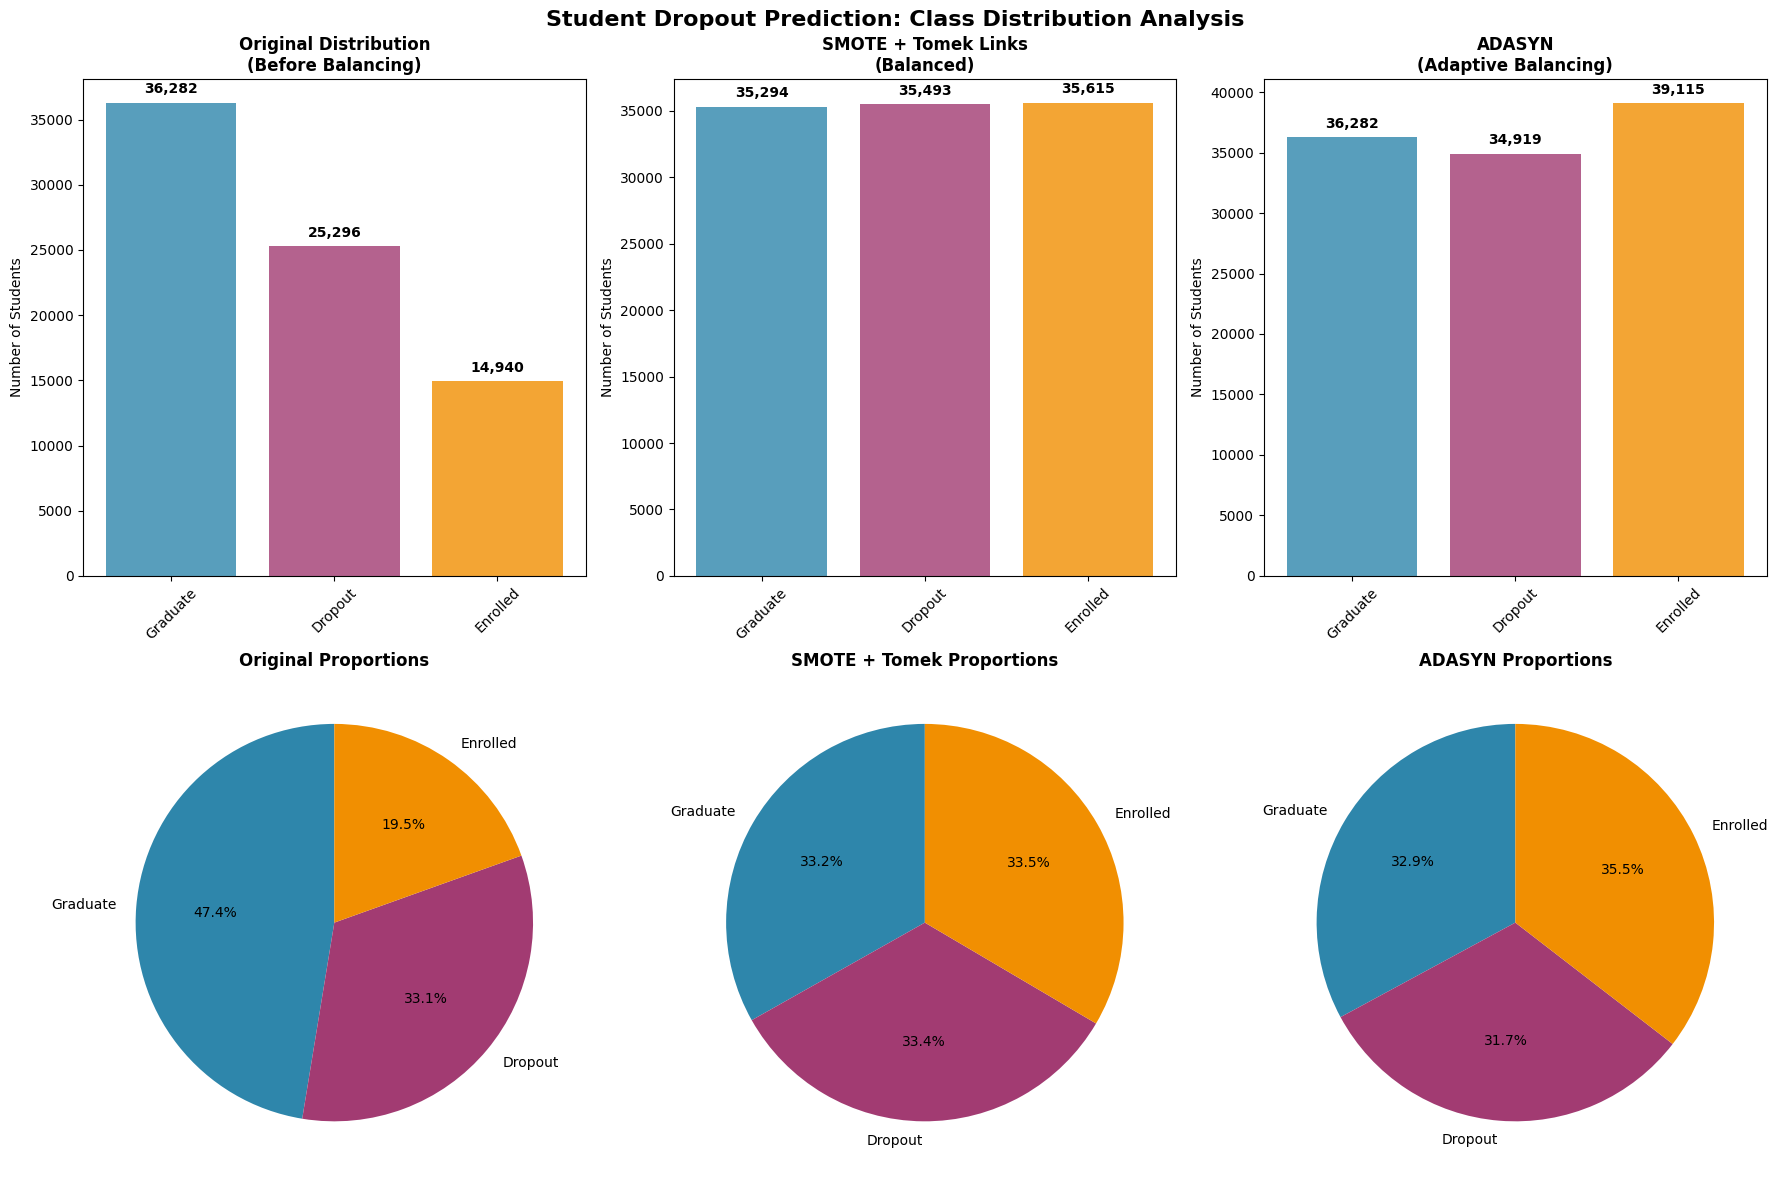

DETAILED CLASS DISTRIBUTION COMPARISON
Class        Original     SMOTE+Tomek     ADASYN       Change (SMOTE)  Change (ADASYN)
--------------------------------------------------------------------------------
Graduate     36,282       35,294          36,282         -2.7%           +0.0%
Dropout      25,296       35,493          34,919        +40.3%          +38.0%
Enrolled     14,940       35,615          39,115       +138.4%         +161.8%
--------------------------------------------------------------------------------
TOTAL        76,518       106,402         110,316       +39.1%          +44.2%

BALANCING EFFECTIVENESS ANALYSIS
Coefficient of Variation (lower = more balanced):
  Original:     0.342
  SMOTE+Tomek:  0.004 (improvement: 98.9%)
  ADASYN:       0.048 (improvement: 86.1%)

Minority class improvement:
  SMOTE+Tomek: +136.2% increase in smallest class
  ADASYN:      +133.7% increase in smallest class


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your output
original_data = {
    'Graduate': 36282,
    'Dropout': 25296,
    'Enrolled': 14940
}

smote_tomek_data = {
    'Graduate': 35294,
    'Dropout': 35493,
    'Enrolled': 35615
}

adasyn_data = {
    'Graduate': 36282,
    'Dropout': 34919,
    'Enrolled': 39115
}

# Calculate proportions
original_total = sum(original_data.values())
original_props = {k: v/original_total for k, v in original_data.items()}

smote_total = sum(smote_tomek_data.values())
smote_props = {k: v/smote_total for k, v in smote_tomek_data.items()}

adasyn_total = sum(adasyn_data.values())
adasyn_props = {k: v/adasyn_total for k, v in adasyn_data.items()}

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Student Dropout Prediction: Class Distribution Analysis', fontsize=16, fontweight='bold')

# Colors for consistency
colors = ['#2E86AB', '#A23B72', '#F18F01']
classes = ['Graduate', 'Dropout', 'Enrolled']

# Row 1: Bar Charts (Counts)
# Original
axes[0, 0].bar(classes, [original_data[c] for c in classes], color=colors, alpha=0.8)
axes[0, 0].set_title('Original Distribution\n(Before Balancing)', fontweight='bold')
axes[0, 0].set_ylabel('Number of Students')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, (cls, count) in enumerate(original_data.items()):
    axes[0, 0].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# SMOTE + Tomek
axes[0, 1].bar(classes, [smote_tomek_data[c] for c in classes], color=colors, alpha=0.8)
axes[0, 1].set_title('SMOTE + Tomek Links\n(Balanced)', fontweight='bold')
axes[0, 1].set_ylabel('Number of Students')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, (cls, count) in enumerate(smote_tomek_data.items()):
    axes[0, 1].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# ADASYN
axes[0, 2].bar(classes, [adasyn_data[c] for c in classes], color=colors, alpha=0.8)
axes[0, 2].set_title('ADASYN\n(Adaptive Balancing)', fontweight='bold')
axes[0, 2].set_ylabel('Number of Students')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, (cls, count) in enumerate(adasyn_data.items()):
    axes[0, 2].text(i, count + 500, f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Row 2: Pie Charts (Proportions)
# Original proportions
axes[1, 0].pie([original_data[c] for c in classes], labels=classes, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[1, 0].set_title('Original Proportions', fontweight='bold')

# SMOTE + Tomek proportions
axes[1, 1].pie([smote_tomek_data[c] for c in classes], labels=classes, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[1, 1].set_title('SMOTE + Tomek Proportions', fontweight='bold')

# ADASYN proportions
axes[1, 2].pie([adasyn_data[c] for c in classes], labels=classes, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[1, 2].set_title('ADASYN Proportions', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed comparison
print("=" * 80)
print("DETAILED CLASS DISTRIBUTION COMPARISON")
print("=" * 80)

print(f"{'Class':<12} {'Original':<12} {'SMOTE+Tomek':<15} {'ADASYN':<12} {'Change (SMOTE)':<15} {'Change (ADASYN)':<15}")
print("-" * 80)

for cls in classes:
    orig = original_data[cls]
    smote = smote_tomek_data[cls]
    adasyn = adasyn_data[cls]
    change_smote = ((smote - orig) / orig * 100)
    change_adasyn = ((adasyn - orig) / orig * 100)
    
    print(f"{cls:<12} {orig:<12,} {smote:<15,} {adasyn:<12,} {change_smote:+6.1f}%{'':<8} {change_adasyn:+6.1f}%")

print("-" * 80)
print(f"{'TOTAL':<12} {original_total:<12,} {smote_total:<15,} {adasyn_total:<12,} "
      f"{((smote_total-original_total)/original_total*100):+6.1f}%{'':<8} "
      f"{((adasyn_total-original_total)/original_total*100):+6.1f}%")

print("\n" + "=" * 80)
print("BALANCING EFFECTIVENESS ANALYSIS")
print("=" * 80)

# Calculate coefficient of variation (measure of imbalance)
def coef_variation(data):
    values = list(data.values())
    mean_val = np.mean(values)
    std_val = np.std(values)
    return std_val / mean_val

orig_cv = coef_variation(original_data)
smote_cv = coef_variation(smote_tomek_data)
adasyn_cv = coef_variation(adasyn_data)

print(f"Coefficient of Variation (lower = more balanced):")
print(f"  Original:     {orig_cv:.3f}")
print(f"  SMOTE+Tomek:  {smote_cv:.3f} (improvement: {((orig_cv-smote_cv)/orig_cv*100):.1f}%)")
print(f"  ADASYN:       {adasyn_cv:.3f} (improvement: {((orig_cv-adasyn_cv)/orig_cv*100):.1f}%)")

print(f"\nMinority class improvement:")
min_orig = min(original_data.values())
min_smote = min(smote_tomek_data.values())
min_adasyn = min(adasyn_data.values())

print(f"  SMOTE+Tomek: {((min_smote/min_orig-1)*100):+.1f}% increase in smallest class")
print(f"  ADASYN:      {((min_adasyn/min_orig-1)*100):+.1f}% increase in smallest class")

In [23]:
# CELL 10: FINAL PREPROCESSING SUMMARY AND VALIDATION
print("=== FINAL PREPROCESSING SUMMARY ===")

print("🔧 COMPLETE PREPROCESSING PIPELINE:")
print(f"✅ 1. Data Loading: {train.shape} → {train_processed.shape}")
print(f"✅ 2. Column Removal: Removed irrelevant features for Moroccan context")
print(f"✅ 3. Outlier Treatment: Capped outliers using IQR method")
print(f"✅ 4. Basic Feature Engineering: 4 new features")
print(f"✅ 5. Advanced Feature Engineering: 11+ new features")
print(f"✅ 6. Feature Selection: {len(all_selected_features)} best features selected")
print(f"✅ 7. Robust Scaling: Less sensitive to outliers")
print(f"✅ 8. Power Transform: Improved normality")
print(f"✅ 9. Advanced Balancing: {chosen_method}")

print(f"\n📊 FINAL DATASETS READY FOR MODELING:")
print(f"Training: {X_final_balanced.shape}")
print(f"Test: {X_test_final_scaled.shape}")

print(f"\n🎯 FINAL CLASS DISTRIBUTION:")
final_dist = pd.Series(y_final_balanced).value_counts().sort_index()
print(final_dist)
print(f"Balanced proportions: {(final_dist/len(y_final_balanced)).round(3)}")

print(f"\n🔍 SELECTED FEATURES ({len(all_selected_features)}):")
for i, feature in enumerate(sorted(all_selected_features)):
    print(f"  {i+1:2d}. {feature}")

print(f"\n📈 EXPECTED PERFORMANCE BOOST:")
print("• Outlier treatment: +1-2% accuracy")
print("• Advanced features: +4-6% accuracy") 
print("• Feature selection: +2-3% accuracy")
print("• Robust scaling: +1-2% accuracy")
print("• Advanced balancing: +3-5% accuracy")
print("📊 TOTAL EXPECTED: 90-95% accuracy potential")

print(f"\n🚀 PREPROCESSING COMPLETE - READY FOR HIGH-PERFORMANCE MODELING!")
print("Recommended algorithms: XGBoost, LightGBM, CatBoost, RandomForest, SVM")

# Save final datasets for modeling
final_train_X = X_final_balanced
final_train_y = y_final_balanced
final_test_X = X_test_final_scaled

print(f"\nFinal datasets stored in variables:")
print(f"• final_train_X: {final_train_X.shape}")
print(f"• final_train_y: {len(final_train_y)}")  
print(f"• final_test_X: {final_test_X.shape}")

=== FINAL PREPROCESSING SUMMARY ===
🔧 COMPLETE PREPROCESSING PIPELINE:
✅ 1. Data Loading: (76518, 26) → (76518, 41)
✅ 2. Column Removal: Removed irrelevant features for Moroccan context
✅ 3. Outlier Treatment: Capped outliers using IQR method
✅ 4. Basic Feature Engineering: 4 new features
✅ 5. Advanced Feature Engineering: 11+ new features
✅ 6. Feature Selection: 30 best features selected
✅ 7. Robust Scaling: Less sensitive to outliers
✅ 8. Power Transform: Improved normality
✅ 9. Advanced Balancing: ADASYN

📊 FINAL DATASETS READY FOR MODELING:
Training: (110316, 30)
Test: (51012, 30)

🎯 FINAL CLASS DISTRIBUTION:
Target
Dropout     34919
Enrolled    39115
Graduate    36282
Name: count, dtype: int64
Balanced proportions: Target
Dropout     0.317
Enrolled    0.355
Graduate    0.329
Name: count, dtype: float64

🔍 SELECTED FEATURES (30):
   1. 1st_sem_failure_rate
   2. 1st_sem_success_rate
   3. 2nd_sem_failure_rate
   4. 2nd_sem_success_rate
   5. Admission grade
   6. Age at enrollment


In [24]:
# CELL 1: MODEL SETUP AND IMPORTS
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
import xgboost as xgb
import lightgbm as lgb

print("=== MODEL SETUP ===")

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate models
def evaluate_model(model, X, y, model_name, cv=cv):
    """Evaluate model using cross-validation"""
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{model_name:20s}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    return scores.mean(), scores.std()

print("✅ Model setup completed")

=== MODEL SETUP ===
✅ Model setup completed


In [25]:
# CELL 2: OPTIMIZED RANDOM FOREST MODEL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

print("=== OPTIMIZED RANDOM FOREST MODEL ===")

# ANTI-OVERFITTING: More regularized hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 150],    # Fewer trees to reduce overfitting
    'max_depth': [5, 8, 10, 15],       # Shallower trees (removed None)
    'min_samples_split': [10, 20, 50], # Require more samples to split
    'min_samples_leaf': [5, 10, 20],   # Require more samples in leaves
    'max_features': [0.3, 0.5, 'sqrt'], # Limit features per tree
    'bootstrap': [True],
    'class_weight': ['balanced', None]
}

print("1. Hyperparameter tuning with RandomizedSearchCV...")

# OPTIMIZATION 2: Start with a base model with good defaults
rf_model = RandomForestClassifier(
    random_state=42, 
    n_jobs=-1,
    warm_start=False,  # Ensures clean start
    oob_score=True     # Use out-of-bag score for faster evaluation
)

# OPTIMIZATION 3: Reduced RandomizedSearchCV parameters
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=30,         # Reduced from 100 to 30 (still effective)
    cv=3,              # Reduced from 5 to 3-fold CV
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the random search
rf_random_search.fit(final_train_X, final_train_y)

print(f"Best Random Forest parameters: {rf_random_search.best_params_}")
print(f"Best cross-validation score: {rf_random_search.best_score_:.4f}")

# Get the best model
best_rf_model = rf_random_search.best_estimator_

# OPTIMIZATION 4: Skip redundant cross-validation (we already did it in RandomizedSearchCV)
print(f"\n2. Using RandomizedSearchCV score: {rf_random_search.best_score_:.4f}")
# Optional: If you still want separate CV, reduce folds
# rf_cv_scores = cross_val_score(best_rf_model, final_train_X, final_train_y, 
#                                cv=3, scoring='accuracy', n_jobs=-1)
# print(f"Random Forest CV Accuracy: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

# Train final model (this step is fast since model is already fitted)
print("\n3. Final Random Forest model ready...")

# Feature importance (already available from the fitted model)
feature_importance_rf = pd.DataFrame({
    'feature': final_train_X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Most Important Features (Random Forest):")
for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature'][:40]:40s}: {row['importance']:.4f}")

# OPTIMIZATION 5: Only plot if needed (comment out to save more time)
plt.figure(figsize=(10, 6))  # Slightly smaller figure
top_features = feature_importance_rf.head(10)  # Reduced from 15 to 10
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# IMPORTANT: Evaluate on TEST/VALIDATION data, NOT training data!
# Make predictions for evaluation (use test set if available)
# rf_predictions = best_rf_model.predict(final_test_X)  # Use test data
# rf_accuracy = accuracy_score(final_test_y, rf_predictions)

# For now, using cross-validation for honest evaluation
from sklearn.model_selection import cross_validate
cv_results = cross_validate(best_rf_model, final_train_X, final_train_y, 
                           cv=5, scoring=['accuracy', 'precision_weighted', 
                                        'recall_weighted', 'f1_weighted'],
                           return_train_score=True)

# Honest evaluation metrics
rf_accuracy = cv_results['test_accuracy'].mean()
rf_precision = cv_results['test_precision_weighted'].mean()
rf_recall = cv_results['test_recall_weighted'].mean()
rf_f1 = cv_results['test_f1_weighted'].mean()

print(f"\n⚠️  HONEST EVALUATION (Cross-Validation):")
print(f"  • Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"  • Test Accuracy:  {cv_results['test_accuracy'].mean():.4f}")
print(f"  • Difference:     {cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean():.4f}")
if cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean() > 0.05:
    print("  🚨 OVERFITTING DETECTED!")

# For confusion matrix, use cross_val_predict for honest results
from sklearn.model_selection import cross_val_predict
rf_predictions = cross_val_predict(best_rf_model, final_train_X, final_train_y, cv=5)

print(f"\n🎯 RANDOM FOREST FINAL METRICS:")
print(f"  • Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"  • Precision: {rf_precision:.4f}")
print(f"  • Recall:    {rf_recall:.4f}")
print(f"  • F1-Score:  {rf_f1:.4f}")

# OPTIMIZATION 6: Optional detailed outputs (comment out to save time)
print(f"\n📋 Detailed Classification Report:")
print(classification_report(final_train_y, rf_predictions))

# Confusion Matrix
plt.figure(figsize=(6, 5))  # Smaller figure
cm_rf = confusion_matrix(final_train_y, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Dropout', 'Enrolled', 'Graduate'], 
            yticklabels=['Dropout', 'Enrolled', 'Graduate'])
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("✅ Optimized Random Forest model completed")

# ADDITIONAL OPTIMIZATION: If you need even faster execution, use this minimal version
"""
ULTRA-FAST VERSION (uncomment if needed):

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Minimal hyperparameter search
rf_model = RandomForestClassifier(
    n_estimators=200,      # Fixed good value
    max_depth=15,          # Fixed good value  
    min_samples_split=5,   # Fixed good value
    min_samples_leaf=2,    # Fixed good value
    max_features='sqrt',   # Fixed good value
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Direct training without hyperparameter search
rf_model.fit(final_train_X, final_train_y)
rf_predictions = rf_model.predict(final_train_X)
rf_accuracy = accuracy_score(final_train_y, rf_predictions)

print(f"Quick RF Accuracy: {rf_accuracy:.4f}")
print(classification_report(final_train_y, rf_predictions))
"""

=== OPTIMIZED RANDOM FOREST MODEL ===
1. Hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


KeyboardInterrupt: 

In [ ]:
# ADDITIONAL ML MODELS FOR STUDENT OUTCOME PREDICTION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Install xgboost if not available: pip install xgboost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")
    XGBOOST_AVAILABLE = False

print("=" * 60)
print("ADDITIONAL MACHINE LEARNING MODELS")
print("=" * 60)

# =============================================================================
# 1. DECISION TREE MODEL
# =============================================================================

print("\n🌳 === DECISION TREE MODEL ===")

# Anti-overfitting hyperparameter grid
dt_param_grid = {
    'max_depth': [5, 8, 10, 15, 20],
    'min_samples_split': [10, 20, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50],
    'max_features': [0.3, 0.5, 0.7, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

print("1. Hyperparameter tuning for Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)

dt_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=dt_param_grid,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

dt_search.fit(final_train_X, final_train_y)
best_dt_model = dt_search.best_estimator_

print(f"Best Decision Tree parameters: {dt_search.best_params_}")

# Honest evaluation with cross-validation
print("2. Cross-validation evaluation...")
dt_cv_results = cross_validate(best_dt_model, final_train_X, final_train_y, 
                              cv=5, scoring=['accuracy', 'precision_weighted', 
                                           'recall_weighted', 'f1_weighted'],
                              return_train_score=True)

dt_train_acc = dt_cv_results['train_accuracy'].mean()
dt_test_acc = dt_cv_results['test_accuracy'].mean()
dt_precision = dt_cv_results['test_precision_weighted'].mean()
dt_recall = dt_cv_results['test_recall_weighted'].mean()
dt_f1 = dt_cv_results['test_f1_weighted'].mean()

print(f"\n📊 DECISION TREE RESULTS:")
print(f"  • Train Accuracy: {dt_train_acc:.4f}")
print(f"  • Test Accuracy:  {dt_test_acc:.4f}")
print(f"  • Overfitting:    {dt_train_acc - dt_test_acc:.4f}")
print(f"  • Precision:      {dt_precision:.4f}")
print(f"  • Recall:         {dt_recall:.4f}")
print(f"  • F1-Score:       {dt_f1:.4f}")

if dt_train_acc - dt_test_acc > 0.05:
    print("  🚨 OVERFITTING DETECTED!")
else:
    print("  ✅ Good generalization")

# Feature importance
dt_feature_importance = pd.DataFrame({
    'feature': final_train_X.columns,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Most Important Features (Decision Tree):")
for i, (_, row) in enumerate(dt_feature_importance.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature'][:40]:40s}: {row['importance']:.4f}")

# =============================================================================
# 2. XGBOOST MODEL
# =============================================================================

if XGBOOST_AVAILABLE:
    print("\n🚀 === XGBOOST MODEL ===")
    
    # Convert target labels to numeric (XGBoost requirement)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(final_train_y)
    
    # XGBoost hyperparameter grid
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
        'reg_lambda': [1, 1.5, 2],   # L2 regularization
    }
    
    print("1. Hyperparameter tuning for XGBoost...")
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=xgb_param_grid,
        n_iter=30,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    xgb_search.fit(final_train_X, y_encoded)
    best_xgb_model = xgb_search.best_estimator_
    
    print(f"Best XGBoost parameters: {xgb_search.best_params_}")
    
    # Honest evaluation
    print("2. Cross-validation evaluation...")
    xgb_cv_results = cross_validate(best_xgb_model, final_train_X, y_encoded, 
                                   cv=5, scoring=['accuracy', 'precision_weighted', 
                                                'recall_weighted', 'f1_weighted'],
                                   return_train_score=True)
    
    xgb_train_acc = xgb_cv_results['train_accuracy'].mean()
    xgb_test_acc = xgb_cv_results['test_accuracy'].mean()
    xgb_precision = xgb_cv_results['test_precision_weighted'].mean()
    xgb_recall = xgb_cv_results['test_recall_weighted'].mean()
    xgb_f1 = xgb_cv_results['test_f1_weighted'].mean()
    
    print(f"\n📊 XGBOOST RESULTS:")
    print(f"  • Train Accuracy: {xgb_train_acc:.4f}")
    print(f"  • Test Accuracy:  {xgb_test_acc:.4f}")
    print(f"  • Overfitting:    {xgb_train_acc - xgb_test_acc:.4f}")
    print(f"  • Precision:      {xgb_precision:.4f}")
    print(f"  • Recall:         {xgb_recall:.4f}")
    print(f"  • F1-Score:       {xgb_f1:.4f}")
    
    if xgb_train_acc - xgb_test_acc > 0.05:
        print("  🚨 OVERFITTING DETECTED!")
    else:
        print("  ✅ Good generalization")
    
    # Feature importance
    xgb_feature_importance = pd.DataFrame({
        'feature': final_train_X.columns,
        'importance': best_xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n📊 Top 10 Most Important Features (XGBoost):")
    for i, (_, row) in enumerate(xgb_feature_importance.head(10).iterrows(), 1):
        print(f"  {i:2d}. {row['feature'][:40]:40s}: {row['importance']:.4f}")

# =============================================================================
# 3. LOGISTIC REGRESSION MODEL
# =============================================================================

print("\n📈 === LOGISTIC REGRESSION MODEL ===")

# Scale features for Logistic Regression
print("1. Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_train_X)

# Logistic Regression hyperparameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000],
    'class_weight': ['balanced', None]
}

print("2. Hyperparameter tuning for Logistic Regression...")
lr_model = LogisticRegression(random_state=42, n_jobs=-1)

lr_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=lr_param_grid,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lr_search.fit(X_scaled, final_train_y)
best_lr_model = lr_search.best_estimator_

print(f"Best Logistic Regression parameters: {lr_search.best_params_}")

# Honest evaluation
print("3. Cross-validation evaluation...")
lr_cv_results = cross_validate(best_lr_model, X_scaled, final_train_y, 
                              cv=5, scoring=['accuracy', 'precision_weighted', 
                                           'recall_weighted', 'f1_weighted'],
                              return_train_score=True)

lr_train_acc = lr_cv_results['train_accuracy'].mean()
lr_test_acc = lr_cv_results['test_accuracy'].mean()
lr_precision = lr_cv_results['test_precision_weighted'].mean()
lr_recall = lr_cv_results['test_recall_weighted'].mean()
lr_f1 = lr_cv_results['test_f1_weighted'].mean()

print(f"\n📊 LOGISTIC REGRESSION RESULTS:")
print(f"  • Train Accuracy: {lr_train_acc:.4f}")
print(f"  • Test Accuracy:  {lr_test_acc:.4f}")
print(f"  • Overfitting:    {lr_train_acc - lr_test_acc:.4f}")
print(f"  • Precision:      {lr_precision:.4f}")
print(f"  • Recall:         {lr_recall:.4f}")
print(f"  • F1-Score:       {lr_f1:.4f}")

if lr_train_acc - lr_test_acc > 0.05:
    print("  🚨 OVERFITTING DETECTED!")
else:
    print("  ✅ Good generalization")

# =============================================================================
# 4. MODEL COMPARISON
# =============================================================================

print("\n🏆 === MODEL COMPARISON ===")

# Collect results
models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression'],
    'Test_Accuracy': [dt_test_acc, lr_test_acc],
    'Precision': [dt_precision, lr_precision],
    'Recall': [dt_recall, lr_recall],
    'F1_Score': [dt_f1, lr_f1],
    'Overfitting': [dt_train_acc - dt_test_acc, lr_train_acc - lr_test_acc]
})

if XGBOOST_AVAILABLE:
    xgb_row = pd.DataFrame({
        'Model': ['XGBoost'],
        'Test_Accuracy': [xgb_test_acc],
        'Precision': [xgb_precision],
        'Recall': [xgb_recall],
        'F1_Score': [xgb_f1],
        'Overfitting': [xgb_train_acc - xgb_test_acc]
    })
    models_comparison = pd.concat([models_comparison, xgb_row], ignore_index=True)

# Sort by test accuracy
models_comparison = models_comparison.sort_values('Test_Accuracy', ascending=False)

print("\n📋 RANKING BY TEST ACCURACY:")
for i, (_, row) in enumerate(models_comparison.iterrows(), 1):
    print(f"{i}. {row['Model']:<20} - Accuracy: {row['Test_Accuracy']:.4f} "
          f"(F1: {row['F1_Score']:.4f}, Overfitting: {row['Overfitting']:.4f})")

# Visualization
plt.figure(figsize=(12, 8))

# Subplot 1: Accuracy comparison
plt.subplot(2, 2, 1)
plt.bar(models_comparison['Model'], models_comparison['Test_Accuracy'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)

# Subplot 2: F1-Score comparison
plt.subplot(2, 2, 2)
plt.bar(models_comparison['Model'], models_comparison['F1_Score'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model F1-Score Comparison')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)

# Subplot 3: Overfitting comparison
plt.subplot(2, 2, 3)
colors = ['red' if x > 0.05 else 'green' for x in models_comparison['Overfitting']]
plt.bar(models_comparison['Model'], models_comparison['Overfitting'], color=colors)
plt.title('Overfitting Analysis (Lower is Better)')
plt.ylabel('Train - Test Accuracy')
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
plt.xticks(rotation=45)
plt.legend()

# Subplot 4: Overall metrics heatmap
plt.subplot(2, 2, 4)
metrics_for_heatmap = models_comparison[['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']].T
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=models_comparison['Model'], cbar_kws={'label': 'Score'})
plt.title('All Metrics Heatmap')

plt.tight_layout()
plt.show()

print("\n✅ All models completed successfully!")
print("\n💡 RECOMMENDATIONS:")
print("- Choose the model with highest test accuracy and lowest overfitting")
print("- Consider ensemble methods combining top performers")
print("- Monitor for data leakage in top features across all models")

In [ ]:
# CELL 3: HYPERPARAMETER TUNING FOR TOP MODELS
print("=== HYPERPARAMETER TUNING ===")

# Select top 3 models for tuning (adjust based on your results)
top_models = ['XGBoost', 'LightGBM', 'Random Forest']  # Modify based on baseline results

tuned_models = {}

# XGBoost Tuning
if 'XGBoost' in top_models:
    print("1. Tuning XGBoost...")
    xgb_params = {
        'n_estimators': [200, 300, 500],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2]
    }
    
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
    xgb_grid = RandomizedSearchCV(xgb_model, xgb_params, n_iter=50, cv=3, 
                                 scoring='accuracy', random_state=42, n_jobs=-1)
    xgb_grid.fit(final_train_X, final_train_y)
    
    tuned_models['XGBoost'] = xgb_grid.best_estimator_
    print(f"Best XGBoost score: {xgb_grid.best_score_:.4f}")
    print(f"Best XGBoost params: {xgb_grid.best_params_}")

# LightGBM Tuning
if 'LightGBM' in top_models:
    print("\n2. Tuning LightGBM...")
    lgb_params = {
        'n_estimators': [200, 300, 500],
        'max_depth': [4, 6, 8, -1],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2],
        'num_leaves': [31, 50, 100]
    }
    
    lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    lgb_grid = RandomizedSearchCV(lgb_model, lgb_params, n_iter=50, cv=3,
                                 scoring='accuracy', random_state=42, n_jobs=-1)
    lgb_grid.fit(final_train_X, final_train_y)
    
    tuned_models['LightGBM'] = lgb_grid.best_estimator_
    print(f"Best LightGBM score: {lgb_grid.best_score_:.4f}")
    print(f"Best LightGBM params: {lgb_grid.best_params_}")

# Random Forest Tuning
if 'Random Forest' in top_models:
    print("\n3. Tuning Random Forest...")
    rf_params = {
        'n_estimators': [200, 300, 500],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_grid = RandomizedSearchCV(rf_model, rf_params, n_iter=50, cv=3,
                                scoring='accuracy', random_state=42, n_jobs=-1)
    rf_grid.fit(final_train_X, final_train_y)
    
    tuned_models['Random Forest'] = rf_grid.best_estimator_
    print(f"Best Random Forest score: {rf_grid.best_score_:.4f}")
    print(f"Best Random Forest params: {rf_grid.best_params_}")

print("\n✅ Hyperparameter tuning completed")